# Use Case 2: Semantic Search with Text Embeddings

Code authored by: Shaw Talebi <br>
Article link: https://towardsdatascience.com/text-embeddings-classification-and-semantic-search-8291746220be <br>
Video link: https://youtu.be/sNa_uiqSlJo

### imports

In [1]:
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.metrics import DistanceMetric

import matplotlib.pyplot as plt
import matplotlib as mpl

### load data

In [2]:
df_resume = pd.read_csv('resumes/resumes_train.csv')
df_resume['role'][df_resume['role'].iloc[-1] == df_resume['role']] = "Other" # relabel random role as "other"
df_resume.head()

<ipython-input-2-ca762e19a535>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_resume['role'][df_resume['role'].iloc[-1] == df_resume['role']] = "Other" # relabel random role as "other"


,resume,role
0,### John Doe\n\n---\n\n#### Summary\nDetail-or...,Data Scientist
1,Creating a resume for a Data Scientist based o...,Data Scientist
2,Creating a resume for a Data Scientist...\n\n-...,Data Scientist
3,Creating a resume for a Data Scientist based o...,Data Scientist
4,## John Doe\n\n---\n\n### Summary:\nData Scien...,Data Scientist


### generate embeddings

In [4]:
# import pre-trained model (full list: https://www.sbert.net/docs/pretrained_models.html)
model = SentenceTransformer("all-MiniLM-L6-v2")

# embed vectors
embedding_arr = model.encode(df_resume['resume'])
embedding_arr.shape

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(100, 384)

### Visualize Embeddings

#### PCA

In [5]:
# apply PCA to embeddings
pca = PCA(n_components=2).fit(embedding_arr)
print(pca.explained_variance_ratio_)

[0.20212626 0.12736864]


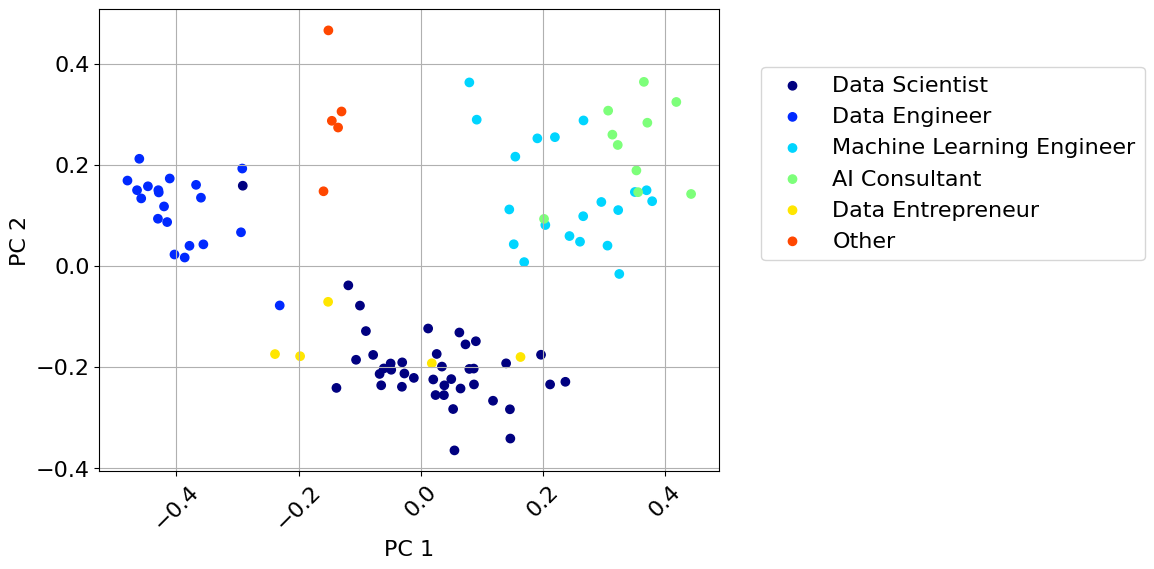

In [6]:
# plot data along PCA components
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.grid()

c=0
cmap = mpl.colormaps['jet']
for role in df_resume['role'].unique():
    idx = np.where(df_resume['role']==role)
    plt.scatter(pca.transform(embedding_arr)[idx,0], pca.transform(embedding_arr)[idx,1], c=[cmap(c)]*len(idx[0]), label=role)
    c = c + 1/len(df_resume['role'].unique())

plt.legend(bbox_to_anchor=(1.05, 0.9))
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

### Semantic Search

In [38]:
query = "I need someone to build out my data infrastructure"
query = "Co-founder for marketing analytics consultancy"
query = "Project manager for AI feature development"
query = "ML Engineer with AI machine learning skills"

In [39]:
# embed query
query_embedding = model.encode(query)

In [40]:
# define distance metric
dist = DistanceMetric.get_metric('euclidean') # other distances: manhattan, chebyshev

# compute pair wise distances between query embedding and all resume embeddings
dist_arr = dist.pairwise(embedding_arr, query_embedding.reshape(1, -1)).flatten()
# sort results
idist_arr_sorted = np.argsort(dist_arr)

In [41]:
# print roles of top 10 closest resumes to query in embedding space
print(df_resume['role'].iloc[idist_arr_sorted[:10]])

78    Machine Learning Engineer
85                AI Consultant
66    Machine Learning Engineer
75    Machine Learning Engineer
70    Machine Learning Engineer
62    Machine Learning Engineer
63    Machine Learning Engineer
86                AI Consultant
65    Machine Learning Engineer
74    Machine Learning Engineer
Name: role, dtype: object


In [42]:
# print resume closest to query in embedding space
print(df_resume['resume'].iloc[idist_arr_sorted[0]])

**Name:** John Smith

---

**Summary:**
Results-driven Machine Learning Engineer with a solid background in developing and implementing machine learning algorithms to solve complex business problems. Proficient in Python, TensorFlow, and Keras. Strong problem-solving skills with a passion for continuous learning and innovation.

---

**Professional Experience:**

*Junior Machine Learning Engineer*  
XYZ Tech Solutions  
- Developed and deployed machine learning models for predictive analytics.  
- Collaborated with cross-functional teams to identify data requirements and extract relevant information.  
- Conducted model tuning and optimization to enhance performance metrics.  

*Machine Learning Intern*  
ABC AI Institute  
- Assisted in building machine learning pipelines and data preprocessing tasks.  
- Conducted data analysis to generate insights and support decision-making processes.  
- Participated in project meetings and presented findings to stakeholders.  

---

**Education:*

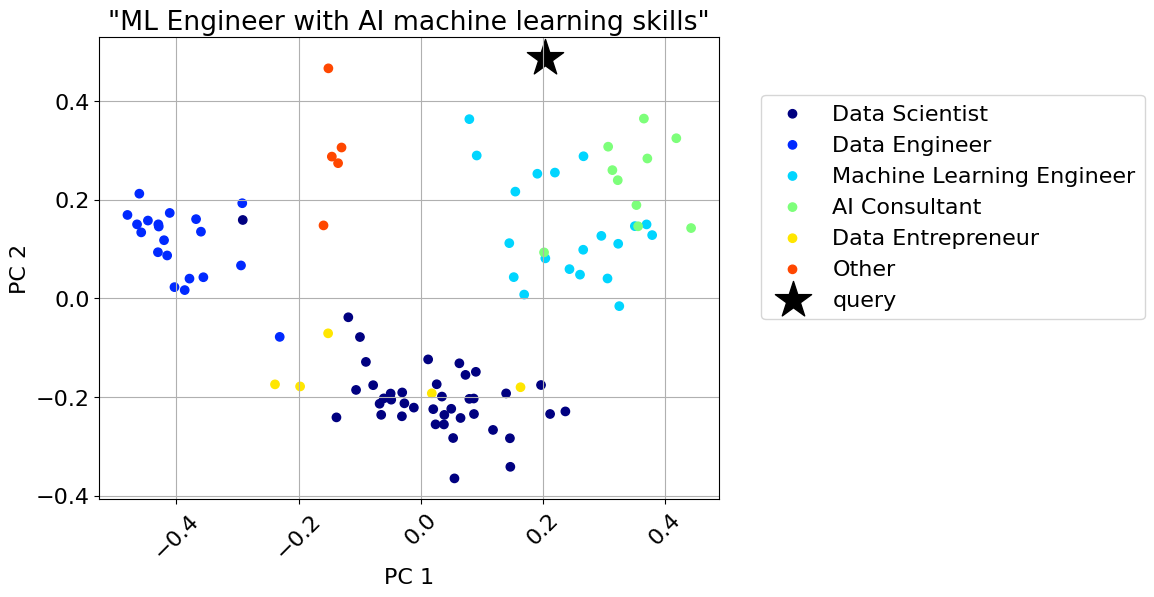

In [43]:
# plot query along with resumes using PCA components
query_pca = pca.transform(query_embedding.reshape(1, -1))[0]

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.grid()

c=0
cmap = mpl.colormaps['jet']
for role in df_resume['role'].unique():
    idx = np.where(df_resume['role']==role)
    plt.scatter(pca.transform(embedding_arr)[idx,0], pca.transform(embedding_arr)[idx,1], c=[cmap(c)]*len(idx[0]), label=role)
    c = c + 1/len(df_resume['role'].unique())

plt.scatter(query_pca[0], query_pca[1], c='k', marker='*', s=750, label='query')

plt.legend(bbox_to_anchor=(1.05, 0.9))
plt.xticks(rotation = 45)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title('"' + query + '"')
plt.show()